In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Unzipping a file in Google Colab
from zipfile import ZipFile
import os

# Path to the zip file
zip_path = '/content/shanghai-22.zip'  # Change this to the path of your .zip file

# Destination directory
extract_dir = '/content'  # Change this if you want a different extraction folder

# Create directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")


Files extracted to: /content


In [3]:
def get_correspondences(book_img, first_frame_gray, distance_threshold=50):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(book_img, None)
    keypoints2, descriptors2 = sift.detectAndCompute(first_frame_gray, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    selected_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

    # Extract corresponding points from selected matches
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in selected_matches])
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in selected_matches])

    # Filter out points that are too close to each other
    filtered_src_pts = []
    filtered_dst_pts = []

    for i, pt1 in enumerate(src_pts):
        # Add the first point to the filtered list
        if len(filtered_src_pts) == 0:
            filtered_src_pts.append(pt1)
            filtered_dst_pts.append(dst_pts[i])
        else:
            # Calculate the distance between the current point and all previous points
            distances = [np.linalg.norm(pt1 - pt2) for pt2 in filtered_src_pts]
            if all(dist > distance_threshold for dist in distances):
                filtered_src_pts.append(pt1)
                filtered_dst_pts.append(dst_pts[i])

    return np.array(filtered_src_pts), np.array(filtered_dst_pts), selected_matches, keypoints1, keypoints2

In [4]:
def normalize_points(points):
    mean = np.mean(points, axis=0)
    std_dev = np.std(points, axis=0)

    scale = np.sqrt(2) / std_dev
    transform = np.array([
        [scale[0], 0, -scale[0] * mean[0]],
        [0, scale[1], -scale[1] * mean[1]],
        [0, 0, 1]
    ])

    # Transform points
    ones = np.ones((points.shape[0], 1))
    points_h = np.hstack((points, ones))
    points_normalized = (transform @ points_h.T).T[:, :2]

    return points_normalized, transform

In [5]:
def compute_homography(src_pts, dst_pts):
    src_pts_norm, T_src = normalize_points(src_pts)
    dst_pts_norm, T_dst = normalize_points(dst_pts)

    A = []
    for i in range(len(src_pts_norm)):
        x, y = src_pts_norm[i]
        x_prime, y_prime = dst_pts_norm[i]
        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])
    A = np.array(A)

    U, S, Vt = np.linalg.svd(A)
    H_norm = Vt[-1].reshape(3, 3)

    # Denormalize the homography
    H = np.linalg.inv(T_dst) @ H_norm @ T_src
    return H / H[2, 2]

In [6]:
def compute_homography_ransac(src_pts, dst_pts, threshold=5.0, max_iterations=1000):
    best_H = None
    best_inliers = None
    max_inliers = 0

    for _ in range(max_iterations):
        # Randomly sample 4 correspondences (minimum for homography)
        sample_indices = np.random.choice(len(src_pts), 4, replace=False)
        src_sample = src_pts[sample_indices]
        dst_sample = dst_pts[sample_indices]

        # Compute homography for the sampled points
        H = compute_homography(src_sample, dst_sample)

        # Compute reprojection errors
        src_pts_h = np.hstack([src_pts, np.ones((len(src_pts), 1))])  # Homogeneous src_pts
        projected_pts = (H @ src_pts_h.T).T  # Project src_pts using H
        projected_pts /= (projected_pts[:, 2][:, None] + 1e-10)  # Safeguard division
        errors = np.linalg.norm(projected_pts[:, :2] - dst_pts, axis=1)  # Reprojection errors

        # Identify inliers
        inliers = errors < threshold
        num_inliers = np.sum(inliers)

        # Update the best model if this one is better
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inliers = inliers

    if best_H is None or max_inliers == 0:
        raise ValueError("RANSAC failed to find a valid homography.")

    # Recompute homography using all inliers
    inlier_src_pts = src_pts[best_inliers]
    inlier_dst_pts = dst_pts[best_inliers]
    final_H = compute_homography(inlier_src_pts, inlier_dst_pts)

    return final_H, best_inliers


In [7]:
def map_book_corners(H, book_img_shape):
    book_corners = np.float32([[0, 0],
                               [book_img_shape[1], 0],
                               [book_img_shape[1], book_img_shape[0]],
                               [0, book_img_shape[0]]]).reshape(-1, 1, 2)
    book_corners_transformed = cv2.perspectiveTransform(book_corners, H)
    book_corners_transformed = np.maximum(book_corners_transformed, 0)
    return book_corners_transformed


In [8]:
def overlay_ar_frame(book_frame, cropped_ar_frame, book_corners):
    # Calculate bounding box of the book corners
    min_x, min_y = np.min(book_corners[:, 0, :], axis=0)
    max_x, max_y = np.max(book_corners[:, 0, :], axis=0)

    # Calculate the dimensions of the bounding box
    width = int(max_x - min_x)
    height = int(max_y - min_y)

    # Calculate aspect ratio of the AR frame
    ar_aspect_ratio = cropped_ar_frame.shape[1] / cropped_ar_frame.shape[0]

    # Calculate new dimensions to fill height
    new_height =  int(height * 1.5)
    new_width = int(height * ar_aspect_ratio)

    # Resize AR frame to new dimensions
    resized_ar_frame = cv2.resize(cropped_ar_frame, (new_width, new_height))

    # Calculate the offset to crop the sides
    x_offset = min_x - (new_width - width) // 2
    y_offset = min_y - 75

    # Define the destination points for the resized AR frame
    dst_points = np.float32([[x_offset, y_offset],
                             [x_offset + new_width, y_offset],
                             [x_offset + new_width, y_offset + new_height-5],
                             [x_offset, y_offset + new_height]])

    # Compute the perspective transform for the resized AR frame
    H_inverse = cv2.getPerspectiveTransform(
        np.float32([[0, 0],
                    [resized_ar_frame.shape[1], 0],
                    [resized_ar_frame.shape[1], resized_ar_frame.shape[0]],
                    [0, resized_ar_frame.shape[0]]]),
        dst_points
    )

    # Warp the AR frame to fit within the book corners
    warped_ar_frame = cv2.warpPerspective(resized_ar_frame, H_inverse, (book_frame.shape[1], book_frame.shape[0]))

    # Create a mask for the warped AR frame
    mask = np.zeros((book_frame.shape[0], book_frame.shape[1]), dtype=np.uint8)
    cv2.fillConvexPoly(mask, book_corners.astype(int), 255)

    # Invert the mask to get the background from the book frame
    mask_inv = cv2.bitwise_not(mask)
    book_frame_bg = cv2.bitwise_and(book_frame, book_frame, mask=mask_inv)

    # Extract the foreground of the AR frame
    ar_fg = cv2.bitwise_and(warped_ar_frame, warped_ar_frame, mask=mask)

    # Combine the background and foreground
    return cv2.add(book_frame_bg, ar_fg)


In [9]:
# Function to check if the corners' movement is within a valid range
def is_valid_corner_movement(corners, expected_corners, max_movement=15):
    corners = np.maximum(corners, 0)
    expected_corners = np.maximum(expected_corners, 0)
    for i in range(4):
        # Calculate the distance between the expected and current corner positions
        dist = np.linalg.norm(corners[i] - expected_corners[i])
        if dist > max_movement:
            return False  # If any corner moves more than the allowed limit, return False
    return True

In [10]:
# Main processing loop with corner movement validation
def create_ar_video_with_visuals(book_video_path, ar_video_path, book_img_path, output_path):
    book_video = cv2.VideoCapture(book_video_path)
    ar_video = cv2.VideoCapture(ar_video_path)
    book_img = cv2.imread(book_img_path, cv2.IMREAD_GRAYSCALE)

    # Initialize VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    ret, first_book_frame = book_video.read()
    out = cv2.VideoWriter(output_path, fourcc, 30, (first_book_frame.shape[1], first_book_frame.shape[0]))

    # Step 1.1: Extract keypoints and compute correspondences
    src_pts, dst_pts, matches, kp1, kp2 = get_correspondences(
        book_img, cv2.cvtColor(first_book_frame, cv2.COLOR_BGR2GRAY)
    )

    # Display the correspondences
    match_visual = cv2.drawMatches(
        book_img, kp1, cv2.cvtColor(first_book_frame, cv2.COLOR_BGR2GRAY),
        kp2, matches, None, flags=2
    )
    plt.figure(figsize=(15, 10))
    plt.imshow(match_visual)
    plt.title("Top 50 Correspondences")
    plt.show()

    # Step 1.2: Compute homography
    H = compute_homography(src_pts, dst_pts)

    # Step 1.3: Calculate book corners in the first frame
    book_corners = map_book_corners(H, book_img.shape)

    # Visualize the book corners on the first frame
    first_frame_with_corners = first_book_frame.copy()
    for i, point in enumerate(book_corners):
        cv2.circle(first_frame_with_corners, tuple(point[0].astype(int)), 10, (0, 255, 0), -1)
        cv2.putText(first_frame_with_corners, f"Corner {i+1}", tuple(point[0].astype(int) + np.array([10, -10])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(first_frame_with_corners, cv2.COLOR_BGR2RGB))
    plt.title("Book Corners in the First Frame")
    plt.show()

    prev_book_corners = book_corners  # Initialize previous corners to None

    # Initialize the old homography as None
    prev_H = H

    while True:
        ret_book, book_frame = book_video.read()
        ret_ar, ar_frame = ar_video.read()
        if not ret_book or not ret_ar:
            break

        # Step 1.1: Extract keypoints and compute correspondences
        src_pts, dst_pts, matches, kp1, kp2 = get_correspondences(
            book_img, cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY)
        )

        # Step 1.2: Compute homography
        H = compute_homography(src_pts, dst_pts)

        # Step 1.3: Calculate book corners
        book_corners = map_book_corners(H, book_img.shape)

        # Step 1.4: Validate corner movement
        if  not is_valid_corner_movement(book_corners, prev_book_corners):
            print("Invalid corner movement, recalculating correspondences...")

            # Attempt to recalculate correspondences
            src_pts, dst_pts, matches, kp1, kp2 = get_correspondences(
                book_img, cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY)
            )
            H,_ = compute_homography_ransac(src_pts, dst_pts)
            book_corners = map_book_corners(H, book_img.shape)

            # Revalidate corner movement
            if not is_valid_corner_movement(book_corners, prev_book_corners):
                print("Recalculated H is also invalid, falling back to previous H.")
                H = prev_H  # Use the previous homography
                book_corners = map_book_corners(H, book_img.shape)

        # Final fallback: Skip the frame if all methods fail
        if not is_valid_corner_movement(book_corners, prev_book_corners):
            print("Corners still invalid after recalculation and fallback, skipping this frame.")
            continue


        # Step 1.7: Overlay AR frame on the book frame
        final_frame = overlay_ar_frame(book_frame, ar_frame, book_corners)

        # Write the final frame to the output video
        out.write(final_frame)

        # Step 1.8: Update previous homography and corners
        prev_H = H  # Update the previous H with the current one
        prev_book_corners = book_corners


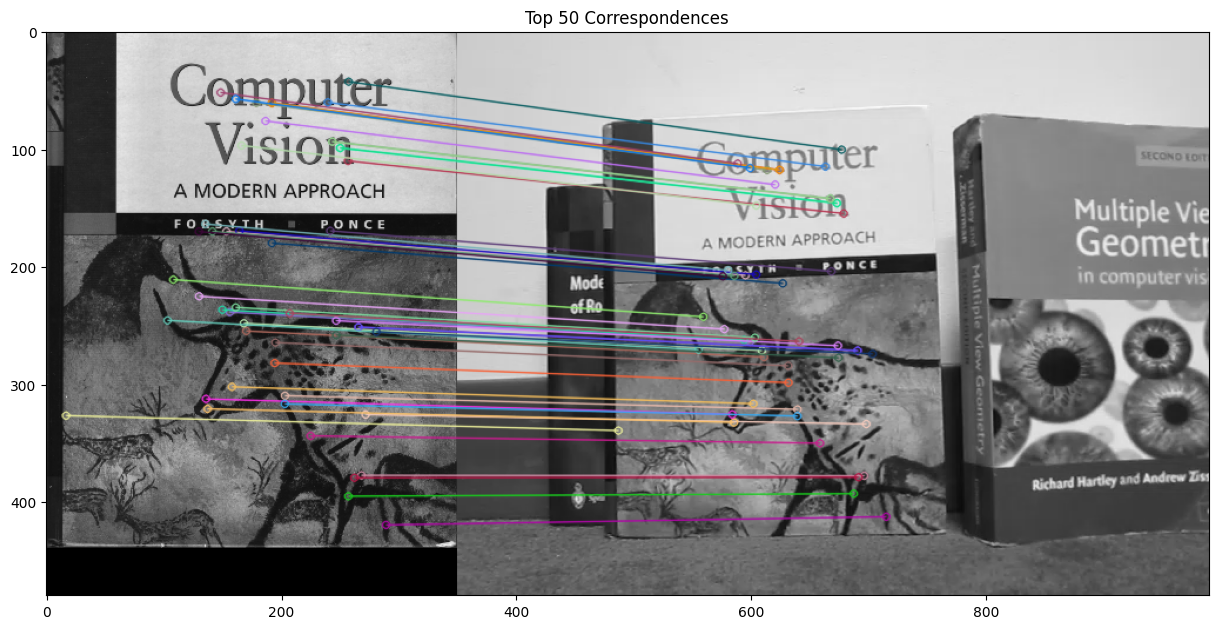

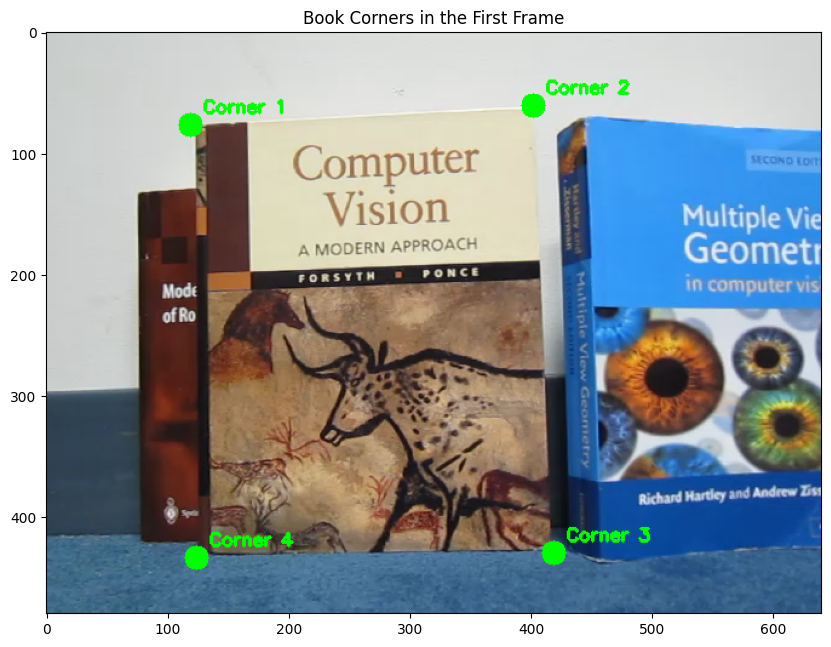

Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...
Invalid corner movement, recalculating correspondences...


In [11]:
create_ar_video_with_visuals('book.mov', 'ar_source.mov', 'cv_cover.jpg', 'ar_output.mov')

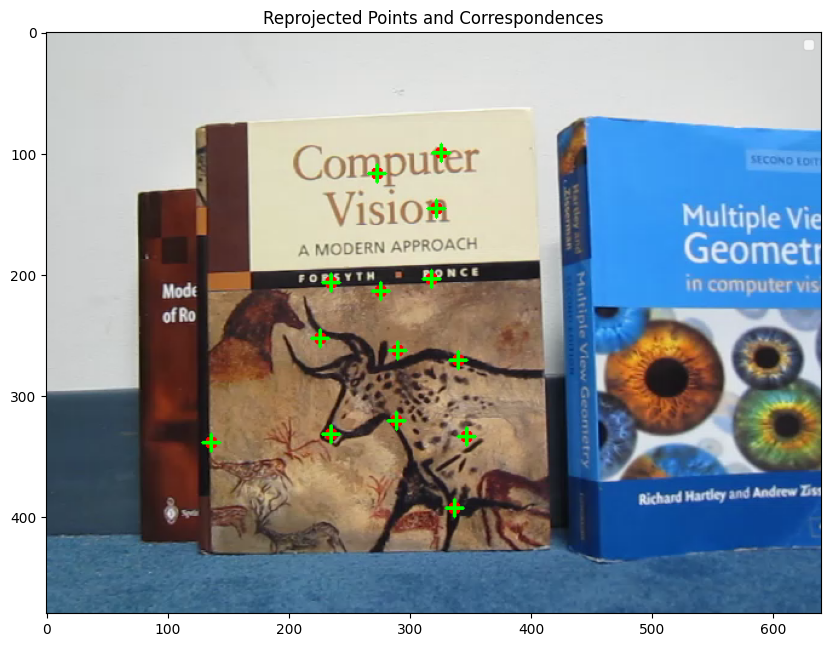

Computed Homography Matrix (H):
[[ 7.69901955e-01  1.48090253e-04  1.19902250e+02]
 [-5.07038199e-02  7.73668013e-01  7.76278682e+01]
 [-9.50417878e-05 -8.51133122e-05  1.00000000e+00]]

Equation p' = Hp for selected points:
Point 1:
Source Point (p): [256.87085 395.4687 ]
Destination Point (p'): [337.1473 393.2426]
Projected Point (p' using H): [227.06250556 253.30006341]
Equation: p' = H * p

Point 2:
Source Point (p): [191.80759 180.00465]
Destination Point (p'): [276.69534 214.3129 ]
Projected Point (p' using H): [273.98418747 117.6591577 ]
Equation: p' = H * p

Point 3:
Source Point (p): [ 16.64707 326.8068 ]
Destination Point (p'): [136.7268  339.58853]
Projected Point (p' using H): [322.72721761 146.31153559]
Equation: p' = H * p

Validation Complete!


In [12]:
def validate_homography(book_img, first_book_frame, src_pts, dst_pts, H):
    # Step 4: Verify the correspondences
    def verify_correspondences(src_pts, dst_pts, H):
        src_pts_h = np.hstack([src_pts, np.ones((len(src_pts), 1))])  # Convert to homogeneous
        projected_pts = (H @ src_pts_h.T).T  # Project points using homography
        projected_pts /= projected_pts[:, 2][:, None]  # Normalize to Cartesian
        errors = np.linalg.norm(projected_pts[:, :2] - dst_pts, axis=1)  # Compute reprojection errors
        return errors, projected_pts[:, :2]

    errors, projected_pts = verify_correspondences(src_pts, dst_pts, H)
    # print("\nReprojection Errors for Correspondences:")
    # for i, error in enumerate(errors):
    #     print(f"Point {i+1}: Error = {error}")

    # Step 5: Visualize projected correspondences
    overlay_img = first_book_frame.copy()
    for i in range(len(dst_pts)):
        # Draw the destination points
        cv2.circle(overlay_img, tuple(dst_pts[i].astype(int)), 5, (0, 0, 255), -1)
        # Draw the projected points
        proj_pt = tuple(projected_pts[i].astype(int))
        cv2.drawMarker(overlay_img, tuple(dst_pts[i].astype(int)), (0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=15, thickness=2)  # Red cross
        cv2.line(overlay_img, tuple(dst_pts[i].astype(int)), proj_pt, (0, 255, 0), 1)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
    plt.title("Reprojected Points and Correspondences")
    plt.legend(['Destination Points (Red)', 'Projected Points (Blue)', 'Line = Mapping'])
    plt.show()

    # Step 1: Display the computed homography matrix
    print("Computed Homography Matrix (H):")
    print(H)
    random_indices = np.random.choice(len(src_pts), 3, replace=False)  # Select 3 random points
    selected_src_pts = src_pts[random_indices]
    selected_dst_pts = dst_pts[random_indices]
    print("\nEquation p' = Hp for selected points:")
    for i in range(3):
        src_pt = selected_src_pts[i]
        dst_pt = selected_dst_pts[i]
        proj_pt = projected_pts[i]
        print(f"Point {i + 1}:")
        print(f"Source Point (p): {src_pt}")
        print(f"Destination Point (p'): {dst_pt}")
        print(f"Projected Point (p' using H): {proj_pt}")
        print(f"Equation: p' = H * p\n")

    print("Validation Complete!")


book_video = cv2.VideoCapture("book.mov")
book_img = cv2.imread('cv_cover.jpg', cv2.IMREAD_GRAYSCALE)
ret, first_book_frame = book_video.read()
# Step 1.1: Extract keypoints and compute correspondences
src_pts, dst_pts, matches, kp1, kp2 = get_correspondences(
    book_img, cv2.cvtColor(first_book_frame, cv2.COLOR_BGR2GRAY)
)
# Example Usage
H = compute_homography(src_pts, dst_pts)  # Homography matrix using your function
validate_homography(book_img, first_book_frame, src_pts, dst_pts, H)